In [1]:
from sklearn import tree
from matplotlib import pyplot as plt # for a good visualization of the trees 
import random
print("Lab 1")

Lab 1


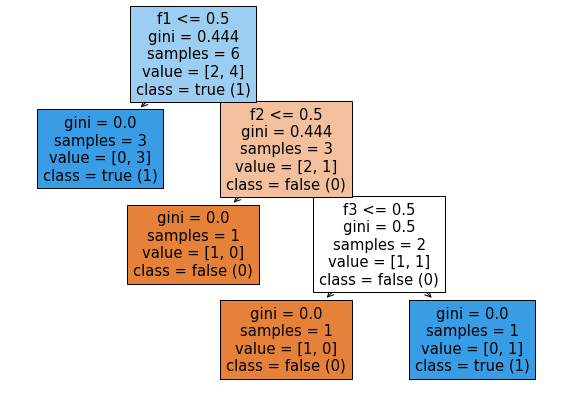

In [2]:
# X is the training set 
# Each example in X has 4 binary features
X = [[0, 0, 1, 0], [0, 1, 0, 1] , [1, 1, 0, 0] , [1, 0, 1, 1] , [0, 0, 0, 1] , [1, 1, 1, 0]]

# Y is the classes associated with the training set. 
# For instance the label of the first and second example is 1; of the third example is 0, etc
Y = [1, 1, 0, 0, 1, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
clf.predict([[1,1,1,1] , [0,1,0,0] , [1,1,0,1] ])
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf, 
                   feature_names= ("f1","f2" , "f3", "f4"),
                   class_names= ("false (0)", "true (1)" ), 
                   filled=True)



----------Part 3----------------
[[1, 1, 1, 0, 0], [0, 1, 0, 1, 1], [1, 1, 1, 1, 0], [0, 1, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 0], [1, 1, 0, 0, 0]]


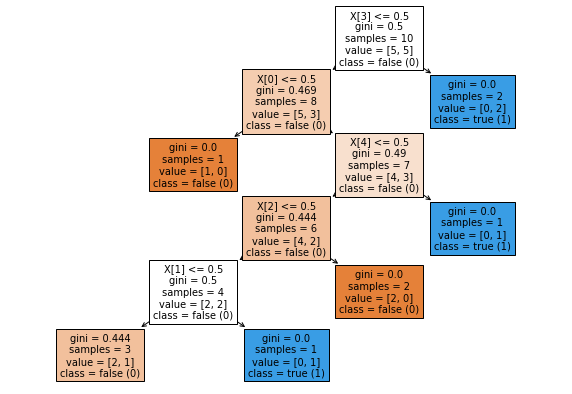

In [3]:
print("----------Part 3----------------")
# X is the training set 
# Each example in X has 4 binary features
model_size = 10
data_size = 5
unknown_data_nb = 5
p = 0.5
p2 = 0.4
def bern(p):
    if(random.random()<p):
        return 0
    return 1
X = [[bern(p) for i in range(data_size)] for j in range(model_size)]
print(X)
# Y is the classes associated with the training set. 
# For instance the label of the first and second example is 1; of the third example is 0, etc
Y = [bern(p2) for k in range(model_size)]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

clf.predict([[bern(p) for i in range(data_size)] for j in range(unknown_data_nb)])
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf, 
                   class_names= ("false (0)", "true (1)" ), 
                   filled=True)


In [4]:
import numpy as np

'''
USEFUL TOOL TO LOAD a DATASET
'''

def load_from_csv(fname):
    """
    Load a dataset from a csv file. The csv file must contain n_samples+1 rows, each with n_features+1
    columns. The last column of each sample is its prediction class, and the first row of the file
    contains the feature names and prediction class name.
    
    Parameters
    ----------
    fname : str
        File name of the csv data file
    
    Returns
    -------
    X : array-like, shape = [n_samples, n_features]
        The sample data

    y : array-line, shape = [n_samples]
        The target values for the sample data
    
    features : list
        A list of strings of length n_features. Specifies the names of each of the features.

    prediction_name : str
        The name of the prediction class
    """

    import csv
    features = []
    prediction_name = ""

    with open(fname, "r") as f:
        features = f.readline().strip().split(",")
        prediction_name = features[-1]
        features = features[0:-1]

    data = np.genfromtxt(fname, dtype=np.uint8, skip_header=1, delimiter=",")

    X = data[:, 0:-1]
    y = data[:, -1]

    return X, y, features, prediction_name

'''
STATISTICAL FAIRNESS RELATED TOOLS

Statistical fairness metrics measure the difference of some value (function of the confusion matrix of a classifier) between two groups of instances (e.g., men and women).
They can be used to assess whether the learnt classifier does not exhibit discrimination (called disparate impact) between the different groups.
'''

import pandas as pd
import numpy as np
from collections import namedtuple

def get_fairness_metric_object(group_1_membership, group_2_membership, y, y_pred):
    """
    Builds a FairnessMetric object given predictions, true labels, and vectors defining two different groups.
    This object can then be used simply to measure the fairness violation between the two groups.
    For instance, to measure the statistical parity unfairness between groups defined by binary attributes 0 and 1:

    unfTraining = get_fairness_metric_object(x_train[:,0], x_train[:,1], y_train, train_preds).statistical_parity()

    The statistical parity measure is equal to the absolute value of the difference between the probabilities of positive outcome between both groups:
    statistical parity unf = | Proba(ŷ = 1 | group 1) - Proba(ŷ = 1 | group 2) |

    For a complete overview of all statistical fairness metrics, refer to https://fairware.cs.umass.edu/papers/Verma.pdf
    For a list of supported fairness metrics, refer to the FairnessMetric object.
    Parameters
    ----------
    group_1_membership: array-line, shape = [n_samples]
        The binary attribute defining group 1 membership

    group_2_membership: array-line, shape = [n_samples]
        The binary attribute defining group 2 membership

    y: array-line, shape = [n_samples]
        The binary true labels
    
    y_pred: array-line, shape = [n_samples]
        The binary predicted labels

    Returns
    -------
    A FairnessMetric object that can be used to measure different statistical fairness metrics between groups 1 and 2 provided by the user
    (given a model's predictions, also provided by the user)
    """
    cm = ConfusionMatrix(group_1_membership, group_2_membership, y_pred, y)
    cm_minority, cm_majority = cm.get_matrix()
    fm = FairnessMetric(cm_minority, cm_majority)

    return fm
    
class ConfusionMatrix(namedtuple('ConfusionMatrix', 'minority majority label truth')):
    """
    Represents a confusion matrix in which some examples belong to a minority group and some others belong to a majority group.
    Both groups are defined using boolean vectors:
    Example use:

    cm = ConfusionMatrix(group_1_membership_array, group_2_membership_array, y_pred, y)

    Groups' confusion matrices can then be retrieved separately.
    Example use:

    cm_minority, cm_majority = cm.get_matrix()
    """
    def get_matrix(self):
        
        TP = np.logical_and(self.label == 1, self.truth == 1)
        FP = np.logical_and(self.label == 1, self.truth == 0)
        FN = np.logical_and(self.label == 0, self.truth == 1)
        TN = np.logical_and(self.label == 0, self.truth == 0)

        #maj
        TP_maj = np.logical_and(TP == 1, self.majority == 1)
        FP_maj = np.logical_and(FP == 1, self.majority == 1)
        FN_maj = np.logical_and(FN == 1, self.majority == 1)
        TN_maj = np.logical_and(TN == 1, self.majority == 1)

        nTP_maj = np.sum(TP_maj)
        nFN_maj = np.sum(FN_maj)
        nFP_maj = np.sum(FP_maj)
        nTN_maj = np.sum(TN_maj)

        nPPV_maj = float(nTP_maj) / max((nTP_maj + nFP_maj), 1)
        nTPR_maj = float(nTP_maj) / max((nTP_maj + nFN_maj), 1)

        nFDR_maj = float(nFP_maj) / max((nFP_maj + nTP_maj), 1)
        nFPR_maj = float(nFP_maj) / max((nFP_maj + nTN_maj), 1)

        nFOR_maj = float(nFN_maj) / max((nFN_maj + nTN_maj), 1)
        nFNR_maj = float(nFN_maj) / max((nFN_maj + nTP_maj), 1)

        nNPV_maj = float(nTN_maj) / max((nTN_maj + nFN_maj), 1)
        nTNR_maj = float(nTN_maj) / max((nTN_maj + nFP_maj), 1)

        #min
        TP_min = np.logical_and(TP == 1, self.minority == 1)
        FP_min = np.logical_and(FP == 1, self.minority == 1)
        FN_min = np.logical_and(FN == 1, self.minority == 1)
        TN_min = np.logical_and(TN == 1, self.minority == 1)

        
        nTP_min = np.sum(TP_min)
        nFN_min = np.sum(FN_min)
        nFP_min = np.sum(FP_min)
        nTN_min = np.sum(TN_min)

        nPPV_min = float(nTP_min) / max((nTP_min + nFP_min), 1)
        nTPR_min = float(nTP_min) / max((nTP_min + nFN_min), 1)

        nFDR_min = float(nFP_min) / max((nFP_min + nTP_min), 1)
        nFPR_min = float(nFP_min) / max((nFP_min + nTN_min), 1)

        nFOR_min = float(nFN_min) / max((nFN_min + nTN_min), 1)
        nFNR_min = float(nFN_min) / max((nFN_min + nTP_min), 1)

        nNPV_min = float(nTN_min) / max((nTN_min + nFN_min), 1)
        nTNR_min = float(nTN_min) / max((nTN_min + nFP_min), 1)

        nPP_maj = float(nTP_maj + nFP_maj) 
        nPP_min = float(nTP_min + nFP_min)

        nPPR_maj = nPP_maj / max((nTP_maj + nFP_maj + nFN_maj + nTN_maj), 1)
        nPPR_min = nPP_min /  max((nTP_min + nFP_min + nFN_min + nTN_min), 1)
        
        matrix_maj = {
            'TP' : nTP_maj,
            'FP' : nFP_maj,
            'FN' : nFN_maj,
            'TN' : nTN_maj,
            'PPV' : nPPV_maj,
            'TPR' : nTPR_maj,
            'FDR' : nFDR_maj,
            'FPR' : nFPR_maj,
            'FOR' : nFOR_maj,
            'FNR' : nFNR_maj,
            'NPV' : nNPV_maj,
            'TNR' : nTNR_maj,
            'PPR': nPPR_maj}

        matrix_min = {
            'TP' : nTP_min,
            'FP' : nFP_min,
            'FN' : nFN_min,
            'TN' : nTN_min,
            'PPV' : nPPV_min,
            'TPR' : nTPR_min,
            'FDR' : nFDR_min,
            'FPR' : nFPR_min,
            'FOR' : nFOR_min,
            'FNR' : nFNR_min,
            'NPV' : nNPV_min,
            'TNR' : nTNR_min,
            'PPR': nPPR_min}

        return matrix_min, matrix_maj

class FairnessMetric(namedtuple('FairnessMetric', 'cm_minority cm_majority')):
    """
    Given two groups' confusion matrices, computes different statistical fairness metrics between the two groups.
    
    Example use:
    fm = FairnessMetric(cm_minority, cm_majority)
    unf = fm.statistical_parity()

    Here, unf measures the statistical parity unfairness between both groups.
    This measure is equal to the absolute value of the difference between the probabilities of positive outcome between both groups:
    statistical parity unf = | Proba(ŷ = 1 | group 1) - Proba(ŷ = 1 | group 2) |

    For a complete overview of all statistical fairness metrics, refer to https://fairware.cs.umass.edu/papers/Verma.pdf
    """
    def statistical_parity(self):
        return np.fabs(self.cm_majority['PPR'] - self.cm_minority['PPR'])
    
    def predictive_parity(self):
        return np.fabs(self.cm_majority['PPV'] - self.cm_minority['PPV'])

    def predictive_equality(self):
        return np.fabs(self.cm_majority['FPR'] - self.cm_minority['FPR'])

    def equal_opportunity(self):
        return np.fabs(self.cm_majority['FNR'] - self.cm_minority['FNR'])

    def conditional_procedure_accuracy_equality(self):
        return (np.fabs(self.cm_majority['TPR'] - self.cm_minority['TPR']) + np.fabs(self.cm_majority['FPR'] - self.cm_minority['FPR']))

    def equalized_odds(self):
        return (np.fabs(self.cm_majority['FNR'] - self.cm_minority['FNR']) + np.fabs(self.cm_majority['FPR'] - self.cm_minority['FPR']))

    def conditional_use_accuracy_equality(self):
        return (np.fabs(self.cm_majority['PPV'] - self.cm_minority['PPV']) + np.fabs(self.cm_majority['NPV'] - self.cm_minority['NPV']))


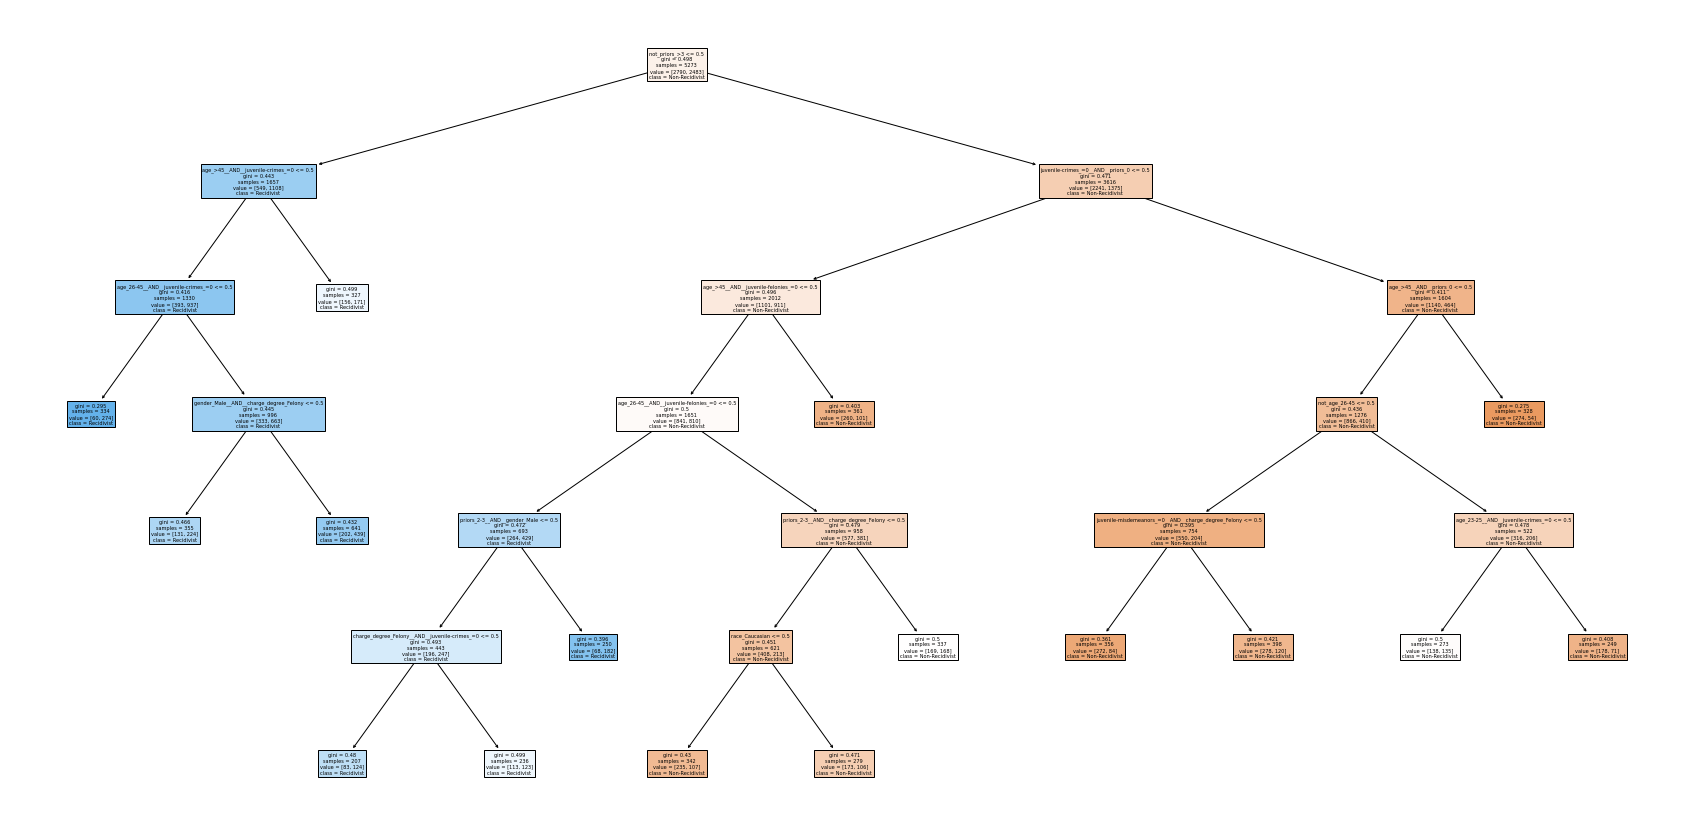

In [8]:
import csv
import numpy as np

train_examples, train_labels, features, prediction = load_from_csv("./compass.csv")

clf = tree.DecisionTreeClassifier(min_samples_leaf = 200)
clf = clf.fit(train_examples, train_labels)
fig = plt.figure(figsize=(30,15))
_ = tree.plot_tree(clf, 
                   feature_names = features,
                   class_names= ("Non-Recidivist", "Recidivist" ), 
                   filled=True)


In [35]:
split_prob = 0.2
selected_training_set, selected_multiple_times, labels_training_set, labels_multiple_times = [],[],[],[]
for k in range(len(train_examples)):
    if(bern(split_prob) == 1):
        selected_training_set.append(train_examples[k])
        labels_training_set.append(train_labels[k])
    else:
        selected_multiple_times.append(train_examples[k])
        labels_multiple_times.append(train_labels[k])
print("Selected training set: ",100*len(selected_training_set) / (len(selected_training_set)+len(selected_multiple_times)),"% of examples")


Selected training set:  80.23895315759529 % of examples


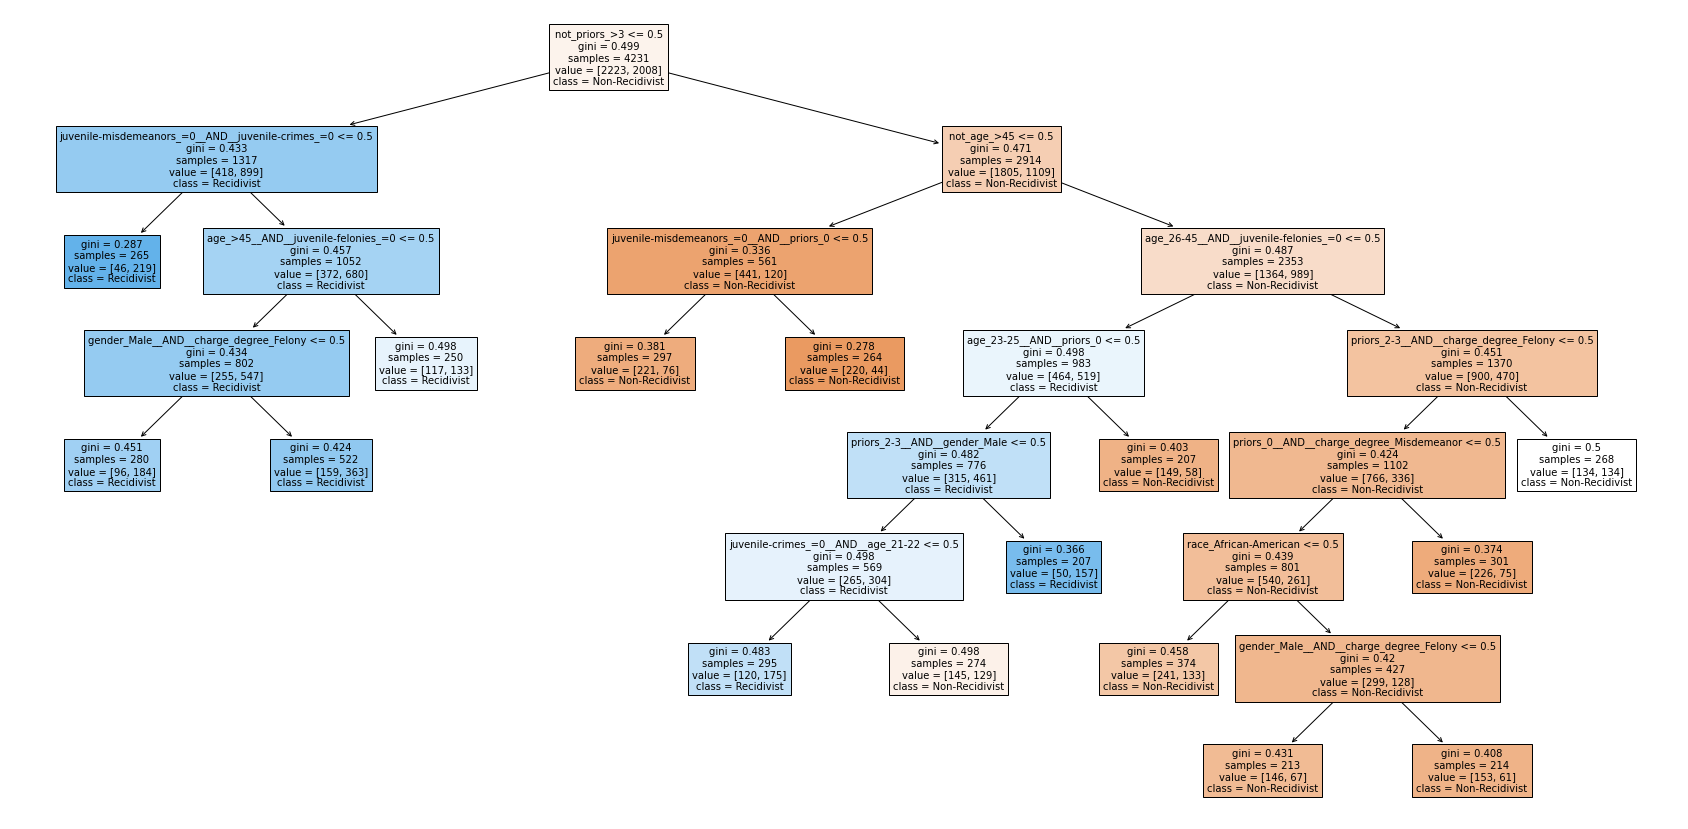

In [42]:
clf = tree.DecisionTreeClassifier(min_samples_leaf = 200)
clf = clf.fit(selected_training_set, labels_training_set)
fig = plt.figure(figsize=(30,15))

_ = tree.plot_tree(clf,
                   fontsize=10,
                   feature_names = features,
                   class_names= ("Non-Recidivist", "Recidivist" ), 
                   filled=True)
